# Introduction to analysis of MC data for CTA using ctapipe

In the following notebook a quick introduction to the analysis of CTA Monte Carlo data using ctapipe is given. This notebook mainly goes through the low-level mono analysis of events, but also the reconstructin of the direction is introduced.

Tasks of the analysis that are covered within this Notebook imply:

- [reading simulation file](#readdata)
- [calibration](#calibration)
- [image cleaning and parametization](#cleaning)
- [low level analysis chain snippet](#template)
- [direction reconstruction](#direction)

For more information see the [documentation](https://cta-observatory.github.io/ctapipe/) of ctapipe and further examples in the the GitHub [repository](https://github.com/cta-observatory/ctapipe/tree/master/ctapipe).

In [1]:
from ctapipe.visualization import CameraDisplay   # plot camera images
from ctapipe.io import event_source               # read rata
from ctapipe.calib import CameraCalibrator        # calibration from r0 to dl1
from ctapipe.calib.camera.gainselection import pick_gain_channel # gain selection
from ctapipe.image.cleaning import tailcuts_clean # image cleaning
from ctapipe.image import hillas_parameters       # parametrization^
from traitlets.config import Config               # handeling of configurations
from ctapipe.reco.HillasReconstructor import \
        HillasReconstructor, TooFewTelescopesException # direction reconstruction
from ctapipe.io import HDF5TableWriter            # write Containers
from ctapipe.io.eventseeker import EventSeeker    # select specific event

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
import os
%matplotlib inline

<a id='readdata'></a>
## Read the data

<span style="color:red">**Important:**</span> To run this Notebook, you need to have at least one smitel file available. If you working locally you could use scp to download the file:

`scp <usrname>@warp-zeuthen.desy.de:/lustre/fs21/group/cta/prod3b/prod3b-paranal20deg/gamma_onSource/
gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged.simtel.gz ~/simtel_files`

Set up `event_source` to read the events from simtel file. The reading of the simulation files is based on the package [pyhessio](https://github.com/cta-observatory/pyhessio).

In [2]:
# example file
file = os.path.expanduser("~/simtel_files/gamma_20deg_180deg_run1\
___cta-prod3_desert-2150m-Paranal-merged.simtel.gz")

source = event_source(file, max_events=15)

Afterwards, `source` allows to access the events with a `for` loop  
```for event in source:  
    do_something()```  
or as iterator `event = next(iter(source))`. A [DataContainer](https://github.com/cta-observatory/ctapipe/blob/2a629c9099083246221349fdc308ffeb061b412d/ctapipe/io/containers.py#L380) is initialized and the informations read for this event are filled in the subcontainers `mc`, `r0` etc.

[EventSeeker](https://github.com/cta-observatory/ctapipe/blob/b9049028a2e682d2053caf4feea8e4770639aa6a/ctapipe/io/eventseeker.py#L11) can be used to select specific event. In the following a event is hand picked to have to have nicer plots of the camera images later on.

In [3]:
seeker = EventSeeker(source)
event = seeker[10]

Higher level information, not read from the file (e.g. `dl1`, `dl2`), will be filled in the course of the analysis. In the following, some more details on the analysis of a single event will be given.

For example, the telescopes that have triggered for this event:

In [4]:
triggered_tels = list(event.r0.tels_with_data)
print("Telescope numbers: {}".format(triggered_tels))

Telescope numbers: [385, 545, 227, 387, 533, 543]


<a id='calibration'></a>
# Calibration
The `r1`, `dl0` and `dl1` containers are filled by the [CameraCalibrator](https://github.com/cta-observatory/ctapipe/blob/5849db486586bc94737d171e611cc782bbe927fa/ctapipe/calib/camera/calibrator.py#L15). Make sure to use the correct `r1_product` for `simtel` files: `r1_product="HESSIOR1Calibrator"`.

In [5]:
print("Calibrated images dl1-level (extracted charge per pixel):")
print("    Before Calibration:\n", event.dl1.tel[triggered_tels[0]].image)

Calibrated images dl1-level (extracted charge per pixel):
    Before Calibration:
 None


In [6]:
calibrator_cfg = Config()
calibrator_cfg["ChargeExtractorFactory"]["product"] = "LocalPeakIntegrator" # peak detection method
calibrator_cfg['WaveformCleanerFactory']['product'] = "NullWaveformCleaner" # waveform cleaning
calibrator_cfg["ChargeExtractorFactory"]["window_width"] = 7 # width of integration window
calibrator_cfg["ChargeExtractorFactory"]["window_shift"] = 3 # shift of integration window

Those settings will be fixed once the CameraCalibrator is initialized. For now, the same calibrator is applied to all camera types.

This is particullary not suitable as different camera types should require different widths and shifts of the integration windows. This was dicussed in [Issue 703](https://github.com/cta-observatory/ctapipe/issues/703) but was not adressed so far.

In [7]:
calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator", config=calibrator_cfg)

[calibrate](https://github.com/cta-observatory/ctapipe/blob/5849db486586bc94737d171e611cc782bbe927fa/ctapipe/calib/camera/calibrator.py#L109) performs the conversions from r0 to dl1 data level. Among those the following tasks are perfomed:  
- [CameraR1Calibrator](https://github.com/cta-observatory/ctapipe/blob/5849db486586bc94737d171e611cc782bbe927fa/ctapipe/calib/camera/r1.py#L30):  
Pedestal substraction and conversion from counts to photoelectrons. In the future those tasks will be perfomed directly in the camera servers. Currently the conversion and substraction are based on values read from the simulation files.
- [CameraDL0Reducer](https://github.com/cta-observatory/ctapipe/blob/5849db486586bc94737d171e611cc782bbe927fa/ctapipe/calib/camera/dl0.py#L16):  
Reduction of the data volume. By default currently not used in ctapipe.
- [CameraDL1Calibrator](https://github.com/cta-observatory/ctapipe/blob/5849db486586bc94737d171e611cc782bbe927fa/ctapipe/calib/camera/dl1.py#L77):  
Trace integration using method specified above. For the extraction of the charge currently a peak finding method is applied to the traces to specify the position of the integration windows.

In [8]:
calibrator.calibrate(event)
print("Calibrated images dl1-level (extracted charge per pixel):")
print("\n    After Calibration:\n", event.dl1.tel[triggered_tels[0]].image)

Calibrated images dl1-level (extracted charge per pixel):

    After Calibration:
 [[2.0381689  1.34502173 1.52014907 ... 0.1592727  1.26375771 1.49906429]]


Depending on the camera, the images might include two gain channels. However, the following ananlysis tasks can only deal with one single gain channel. Later, the selection between those will be perfomed in the cameras, but for now the selection must be done using [pick_gain_channel](https://github.com/cta-observatory/ctapipe/blob/5849db486586bc94737d171e611cc782bbe927fa/ctapipe/calib/camera/gainselection.py#L17).

For each camera with more than one gain channel, a threshold of photo electrons is defined in `pe_thresh`. If this threshold is surpassed in a image, `pick_gain_channel` will select the lower gain channel.

In [9]:
camera = event.inst.subarray.tel[triggered_tels[0]].camera # get camera informations
camera

CameraGeometry(cam_id='CHEC', pix_type='rectangular', npix=2048, cam_rot=0.0 deg, pix_rot=0.0 deg)

In [10]:
# Thresholds for gain channel selection
pe_thresh = {
    "ASTRICam": 14,
    "LSTCam": 100,
    "NectarCam": 190}

if camera.cam_id in pe_thresh.keys():
    # select gain channel
    selected_image, mask = pick_gain_channel(event.dl1.tel[triggered_tels[0]].image,
              pe_thresh[camera.cam_id], select_by_sample=True)
else:
    # for further processing
    selected_image = np.squeeze(event.dl1.tel[triggered_tels[0]].image)
    
selected_image # only one gainchannel left

array([2.0381689 , 1.34502173, 1.52014907, ..., 0.1592727 , 1.26375771,
       1.49906429])

### Display calibrated image

Histogram of the extracted charges in photoelectrons:
<a id='calibratedimage'></a>

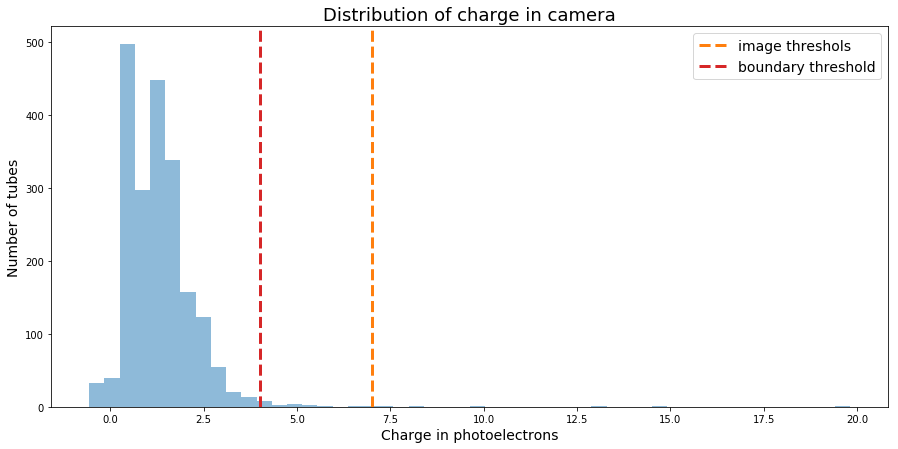

In [11]:
fig = plt.figure(figsize=[15,7])
hist = plt.hist(selected_image, bins=50, log=False, alpha=0.5)
plt.title("Distribution of charge in camera", fontsize=18)
plt.xlabel("Charge in photoelectrons", fontsize=14)
plt.ylabel("Number of tubes", fontsize=14)
# threshold for defining a image pixel
plt.axvline(7, linestyle="--", label="image threshols", color="C1", linewidth=3)
# threshold for defining a boundary pixel
plt.axvline(4, linestyle="--", label="boundary threshold", color="C3", linewidth=3)
plt.legend(fontsize=14)

Calibrated image in comparison to the raw image without the conversion to pe and pedestial substraction.

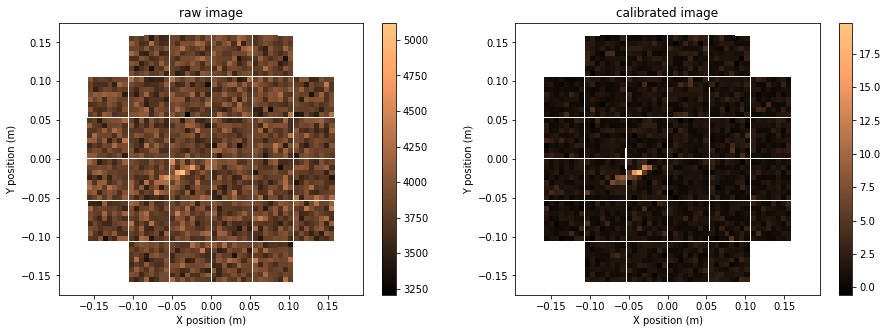

In [12]:
fig = plt.figure(figsize=[15,5])
# plot the raw image
ax1 = plt.subplot(1,2,1)
disp_raw = CameraDisplay(camera, image=event.r0.tel[triggered_tels[0]].image[0],
              cmap="copper", ax=ax1, title="raw image")
disp_raw.add_colorbar() # plot the scale

# plot calibrated image
ax2 = plt.subplot(1,2,2)
disp_calib = CameraDisplay(camera, image=selected_image, cmap="copper",
              ax=ax2, title="calibrated image")
disp_calib.add_colorbar()

<a id='cleaning'></a>
# Image cleaning and parametrization

Cleaning the image using [tailcut cleaning](https://github.com/cta-observatory/ctapipe/blob/b9049028a2e682d2053caf4feea8e4770639aa6a/ctapipe/image/cleaning.py#L10): two thresholds defining the image and boundary pixels (see [histogram of charges](#calibratedimage)). Isolated pixels will not be kept and boundary pixels only if next to a image pixel.  
By default, `tailcuts_clean` will apply the same thresholds for all telescope types. So far there was no final optimization of the values.

In [13]:
# thresholds for tailcuts, not optimized!
tail_thresholds = {
    "ASTRICam": (5, 7),
    "FlashCam": (12, 15),
    "LSTCam": (5, 10),
    "NectarCam": (4, 8),
    "DigiCam": (3, 6),
    "CHEC": (2, 4),
    "SCTCam": (1.5, 3)}

mask = tailcuts_clean(camera, image=selected_image,
                      picture_thresh=tail_thresholds[camera.cam_id][1],
                      boundary_thresh=tail_thresholds[camera.cam_id][0],
                      min_number_picture_neighbors=2)

cleaned_image = np.copy(selected_image) # copy of image
cleaned_image[~mask] = 0 # setting not survived pixels to zero

The cleaned image will be given as input to `hillas_parameters` to calculate the hillas parameters for this event.

In [14]:
params = hillas_parameters(camera, cleaned_image)
params

ctapipe.io.containers.HillasParametersContainer:
                     intensity: total intensity (size)
                             x: centroid x coordinate
                             y: centroid x coordinate
                             r: radial coordinate of centroid
                           phi: polar coordinate of centroid [deg]
                        length: RMS spread along the major-axis
                         width: RMS spread along the minor-axis
                           psi: rotation angle of ellipse [deg]
                      skewness: measure of the asymmetry
                      kurtosis: measure of the tailedness

### Display of cleaning
Example to plot camera images before and after image cleaning of a calibrated event

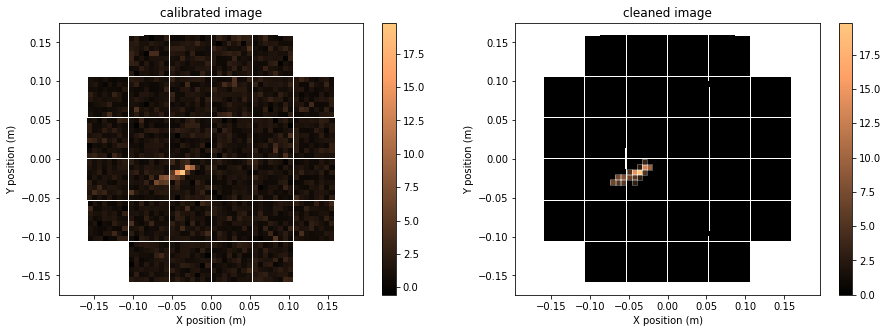

In [15]:
fig = plt.figure(figsize=[15,5])
# plot calibrated image
ax1 = plt.subplot(1,2,1)
disp_calib = CameraDisplay(camera, image=selected_image, cmap="copper",
              ax=ax1, title="calibrated image")
disp_calib.add_colorbar()

# plot cleaned image
ax2 = plt.subplot(1,2,2)
disp_clean = CameraDisplay(camera, image=cleaned_image, cmap="copper",
              ax=ax2, title="cleaned image")
disp_clean.add_colorbar()
# highlight pixels that survived cleaning
disp_clean.highlight_pixels(mask, color='w', alpha=0.3)

Cleaned image including the Hillas ellipses.

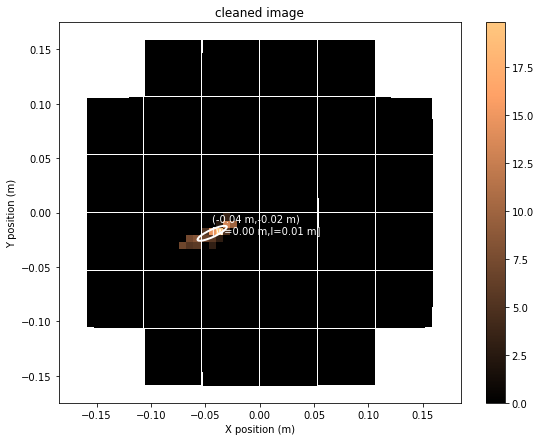

In [16]:
fig = plt.figure(figsize=[9,7])
ax = plt.subplot(1,1,1)
# plot cleaned image
disp_clean = CameraDisplay(camera, image=cleaned_image, cmap="copper",
              ax=ax, title="cleaned image")
disp_clean.add_colorbar()
# show the hillas ellipse
disp_clean.overlay_moments(params, color="w", linewidth=2, alpha=1)

<a id='template'></a>
# Template code snippet for analysis 

The following code snippet should demonstrate, how a basic low level processing for ctapipe could look like. In the following code no quality cuts like size cut or multiplicity are applied. The hillas parameters for each camera type are stored in a HDF file.

A more complete low level analysis script can be found in [here](https://github.com/kpfrang/CTA-analysis/blob/master/Examples/Submit_batch_farm/analyse_file.py).

Parameters needed for the direction reconstruction are collected and stored in variables to use them in the next step.

In [17]:
source = event_source(file, max_events=15) # read the file

with HDF5TableWriter(filename='hillas.h5', group_name='hillas', overwrite=True) as writer:
    
    # start the main loop
    for event in source:
        calibrator.calibrate(event) # fill r1, dl0 and dl1

        # dicts for the direction reconstruction
        parameters = {}
        pointing_az = {}
        pointing_alt = {}
        inst = event.inst

        for tel_id in event.r0.tels_with_data:
            camera = event.inst.subarray.tel[tel_id].camera

            if camera.cam_id in pe_thresh.keys():
                image, mask = pick_gain_channel(
                    event.dl1.tel[tel_id].image, pe_thresh[camera.cam_id],
                    select_by_sample=True)
                
            else:
                # get correct shape for cleaning
                image = np.squeeze(event.dl1.tel[tel_id].image)
            
            #cleaning
            mask = tailcuts_clean(camera, image=image,
                min_number_picture_neighbors=0)

            if not any(mask):
                # no pixel has survived the cleaning
                # move to next telescope
                continue
            
            cleaned_image = np.copy(image) 
            cleaned_image[~mask] = 0
            hillas_params = hillas_parameters(camera, cleaned_image)
            
            # hillas parameters to hdf file
            writer.write(camera.cam_id, hillas_params)
            
            # collect parameters needed for direction reconstruction
            parameters[tel_id] = hillas_params
            pointing_az[tel_id] = event.mc.tel[tel_id].azimuth_raw * u.rad
            pointing_alt[tel_id] = event.mc.tel[tel_id].altitude_raw * u.rad



/Users/konstantinpfrang/Software/ctasoft/ctapipe/ctapipe/image/hillas.py:565: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)


The output can be read using `pytables` or `pandas`. Above the parameters for each camera type were stored to a different table so that they can be read back in seperately. Showing the distributions of all parameters for each camera type.

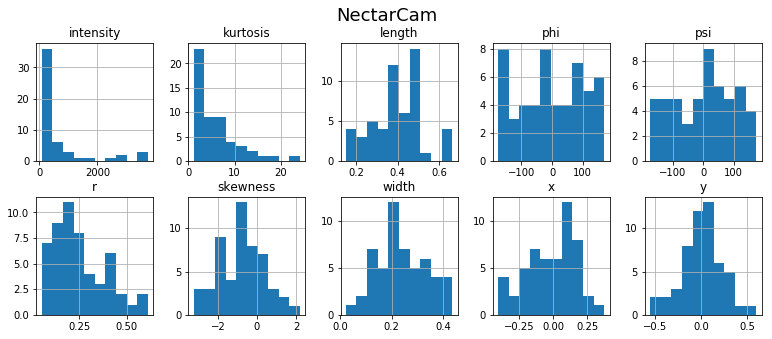

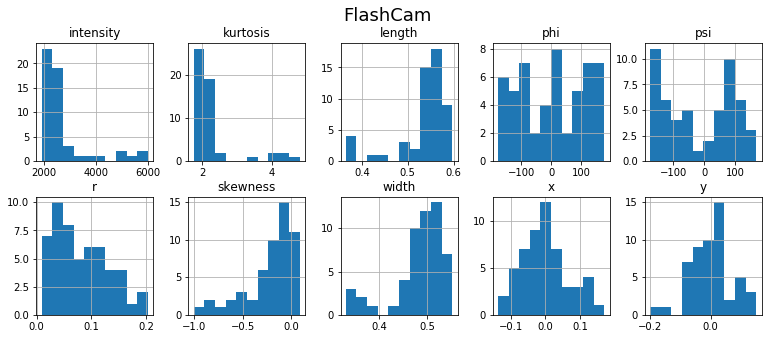

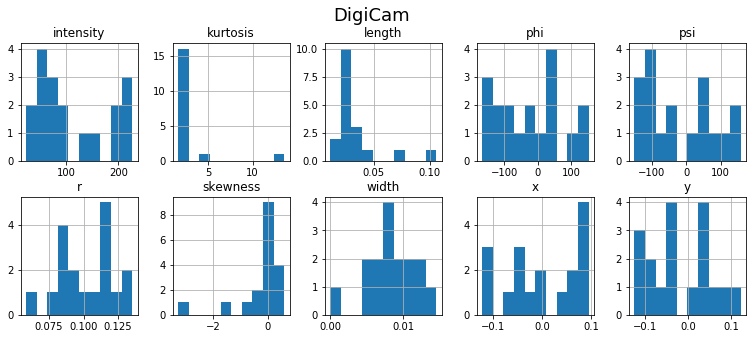

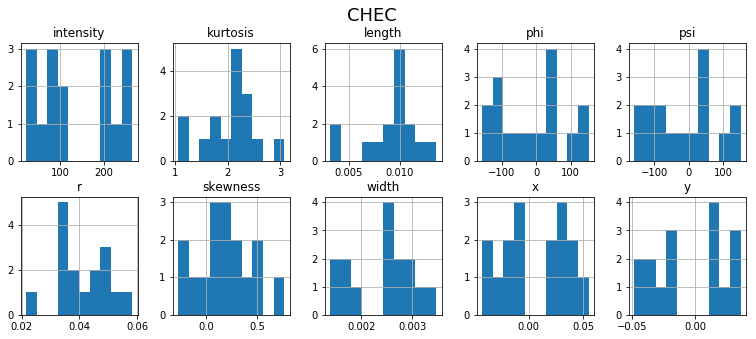

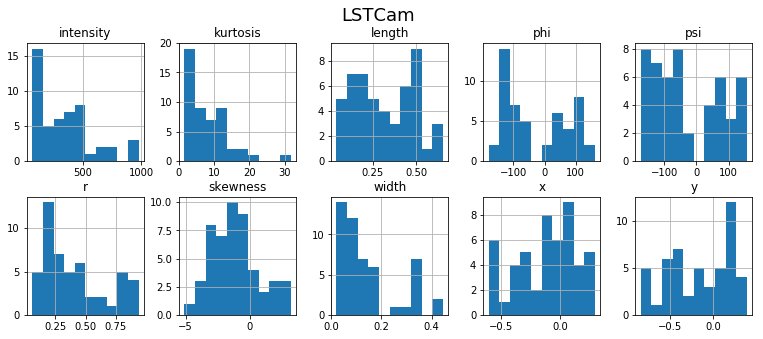

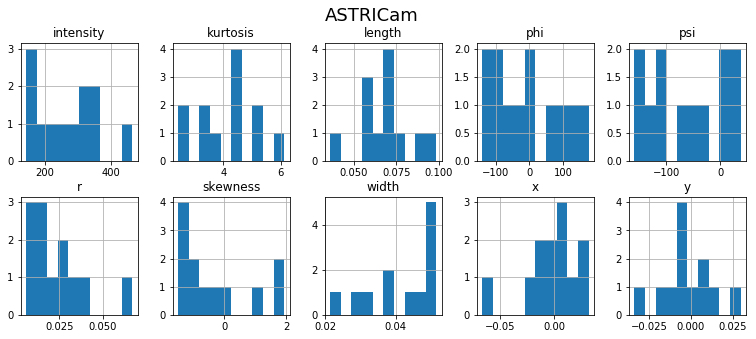

In [18]:
for cam in event.inst.subarray.camera_types:
    hillas = {}
    try:
        hillas[cam] = pd.read_hdf("hillas.h5", key="hillas/{}".format(cam))        
        
        # plot histograms of parameters
        hists = hillas[cam].hist(figsize=(13,5), layout=(2,5))
        plt.suptitle(cam, fontsize=18)
    except KeyError:
        print("No event for {}".format(cam))
        pass

<a id='direction'></a>
## Direction reconstruction
Reconstruction of the direction of the shower and estimation of the impact position on the ground can be done using [HillasReconstructor](https://github.com/cta-observatory/ctapipe/blob/5849db486586bc94737d171e611cc782bbe927fa/ctapipe/reco/HillasReconstructor.py#L63). The following will reconstruct the direction of the last event processed by the code snippet above. It's Hillas parameters are stored in the dictionary `parameters` with the telescope IDs as keys.

The direction is determined using the (weighted) mean of the **intersections** of all hillas planes while the core position is estimated to be the point with the **least linear square** to the "traces" of all telescopes. For details see the [documentation](https://cta-observatory.github.io/ctapipe/api/ctapipe.reco.HillasReconstructor.html#ctapipe.reco.HillasReconstructor).

In [19]:
reconstructor = HillasReconstructor()
try:
    reconstructed_parameters = reconstructor.predict(
                parameters, inst, pointing_alt, pointing_az)
except TooFewTelescopesException:
    # needs at least two telescopes for the reconstruction
    pass

/Users/konstantinpfrang/Software/ctasoft/ctapipe/ctapipe/reco/HillasReconstructor.py:346: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pos = np.linalg.lstsq(A, D)[0] * u.m


Test **goodness of reconstrucion** by checking the agreement of the estimated direction to the MC truth.

In [20]:
agreement_alt = (reconstructed_parameters.alt / event.mc.alt - 1) * 100 * u.percent
agreement_az = (reconstructed_parameters.az / event.mc.az - 1) * 100 * u.percent

print("The true MC and the predicted directions agree by \
{:1.2f} and {:1.2f} for altitude and azimuth respectively.".format(agreement_alt, agreement_az))

The true MC and the predicted directions agree by 0.04 % and 1.09 % for altitude and azimuth respectively.
